<div>
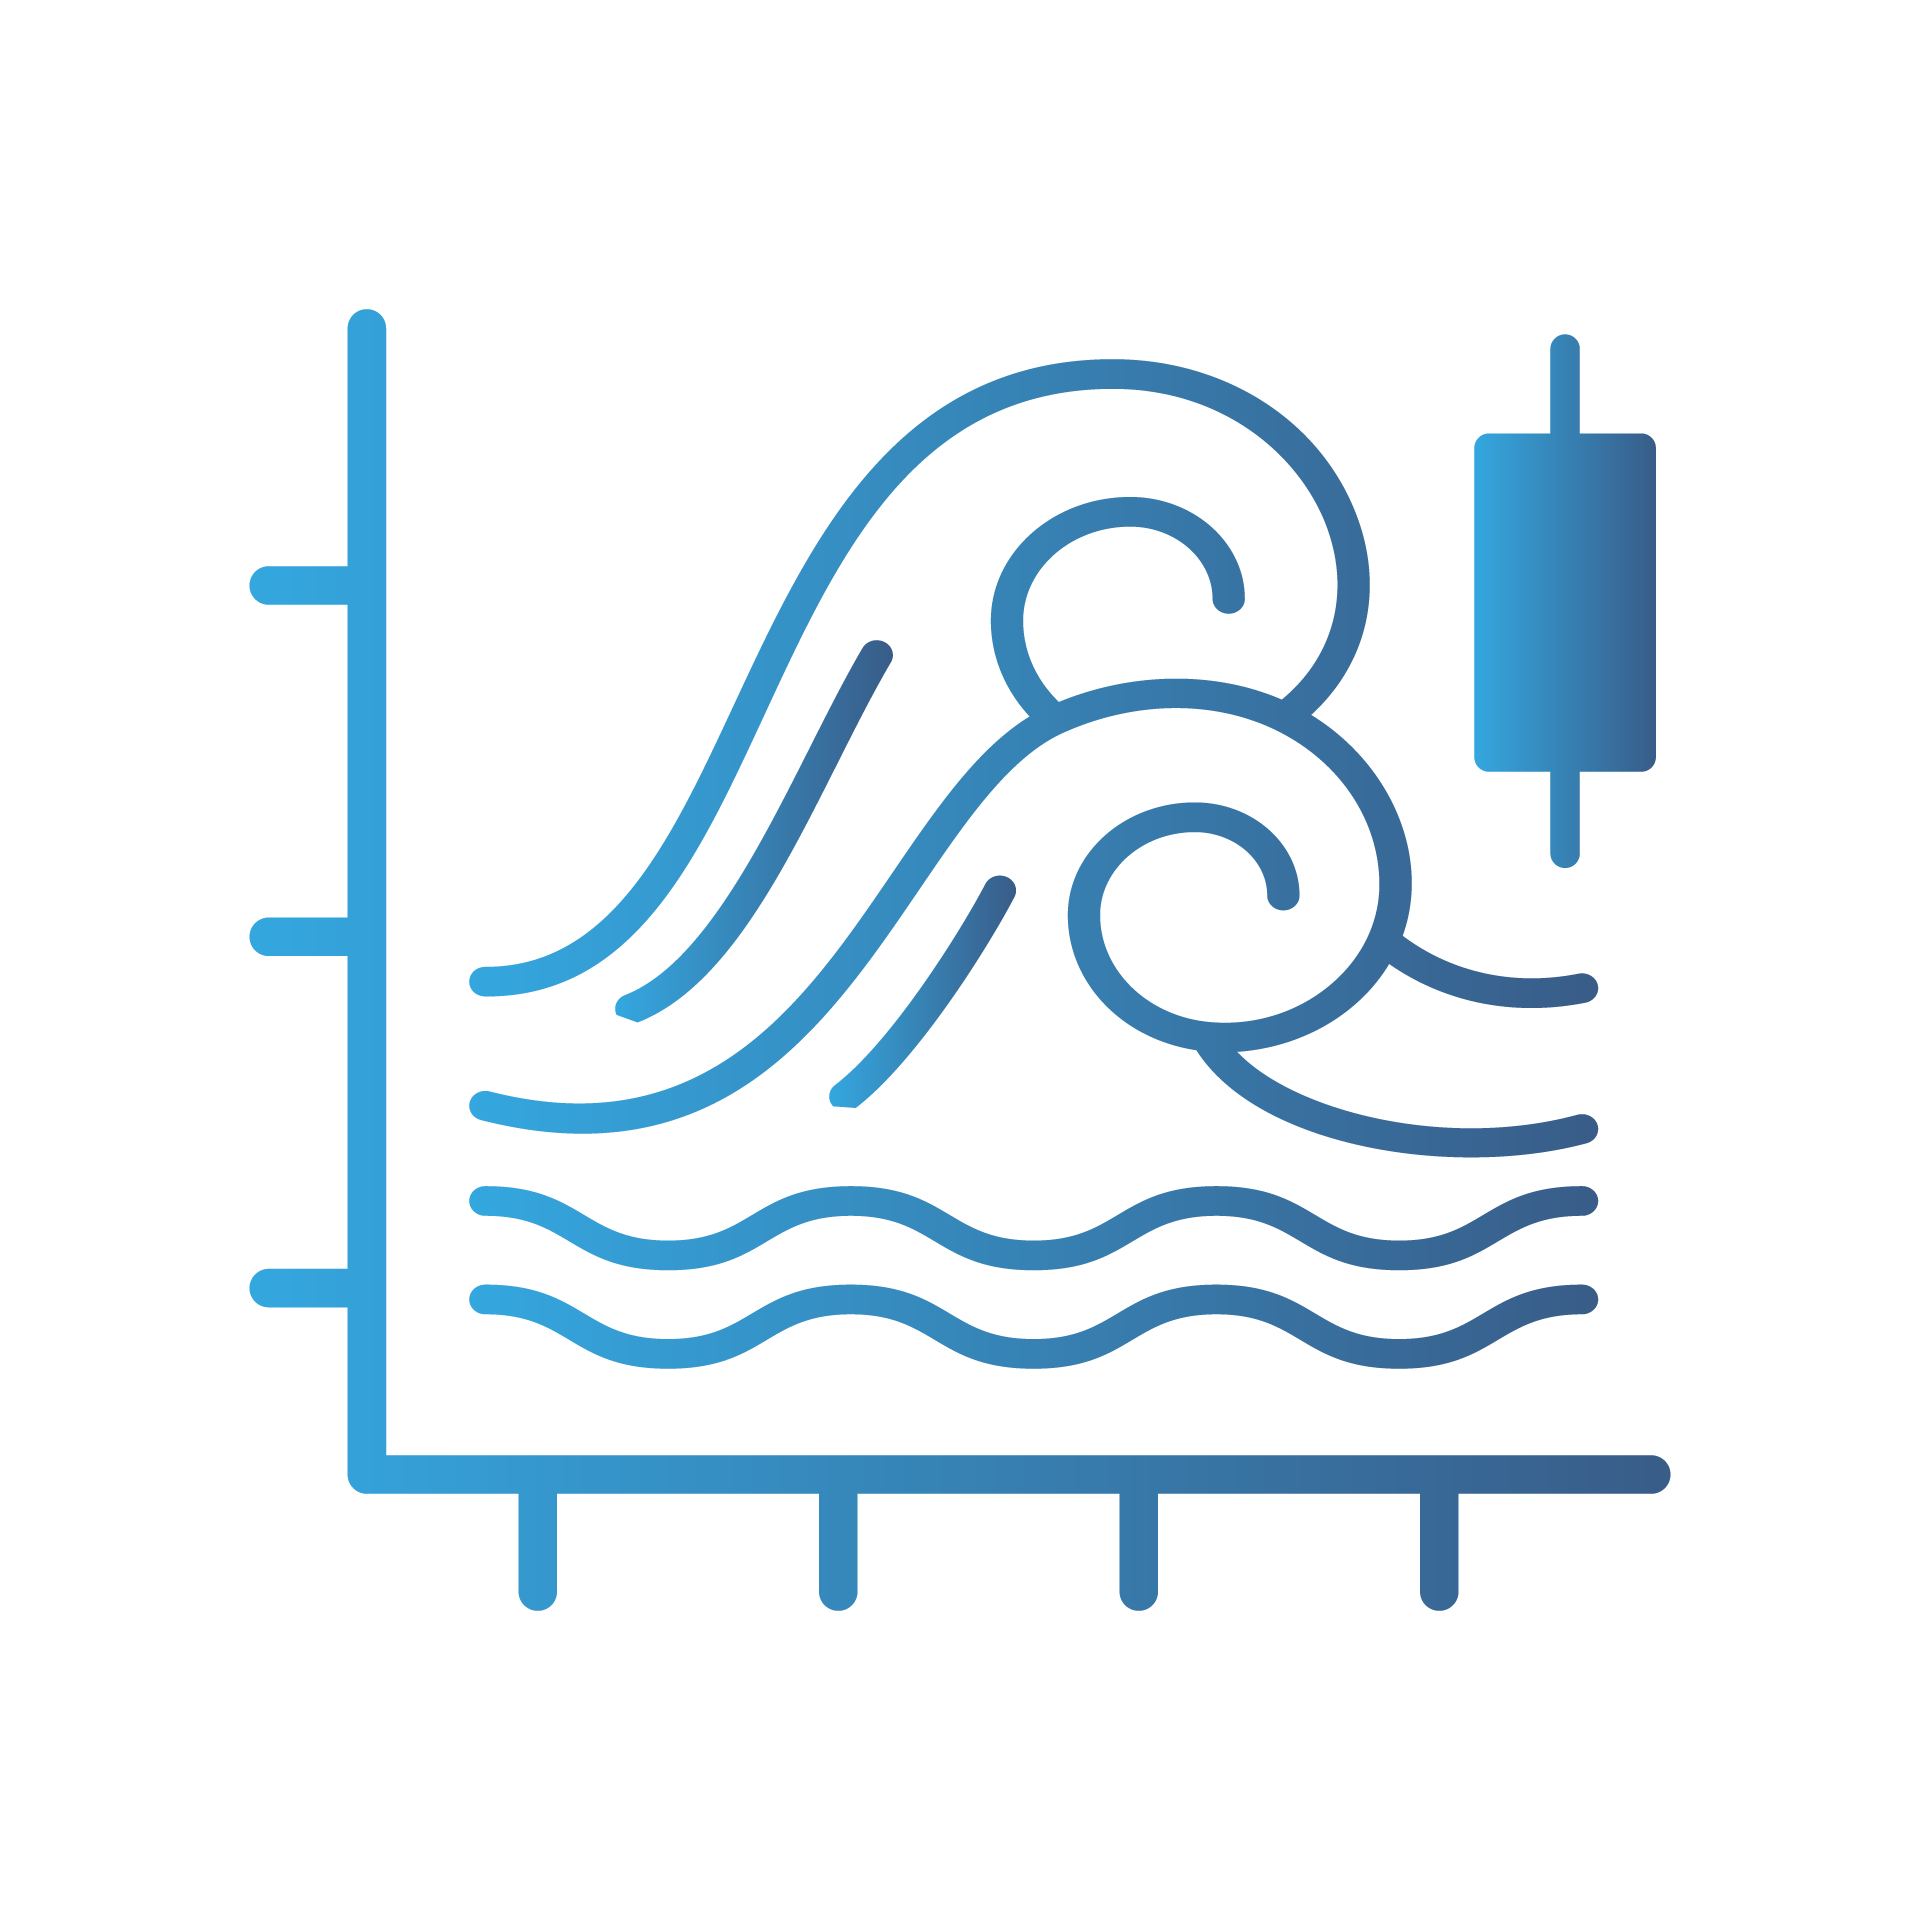
</div>

# __PCM development notebook__

The objective of this notebook is to create a PCM model, optimize the model parameters and fit it to a training dataset.

A PCM (__Profile Classification Model__) allows to automatically assemble ocean profiles in clusters according to their vertical structure similarities. Depending on the dataset, such clusters can show space/time coherence. That is what we call the __ocean patterns indicators__. For more information about the method, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

As an example, a selection of GLOBAL_REANALYSIS_PHY_001_030 CMEMS product covering the Mediterranean is available as training dataset.

Computation is done using the __pyxpcm python software__ (see documentation at https://pyxpcm.readthedocs.io)

The optimazed model you are going to create can be saved and applied to a dataset using *predit_PCMlabels_and_plot.ipynb* notebook, where you can plot and analyze the results.

This notebook have been developped by Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Blue-Cloud project. Blue-Cloud has received funding from the European Union's Horizon programme call BG-07-2019-2020, topic: [A] 2019 - Blue Cloud services, Grant Agreement n.862409


<div>
<center>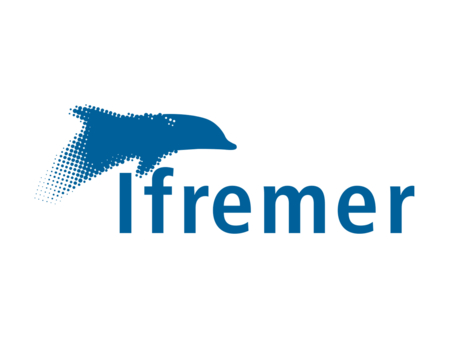 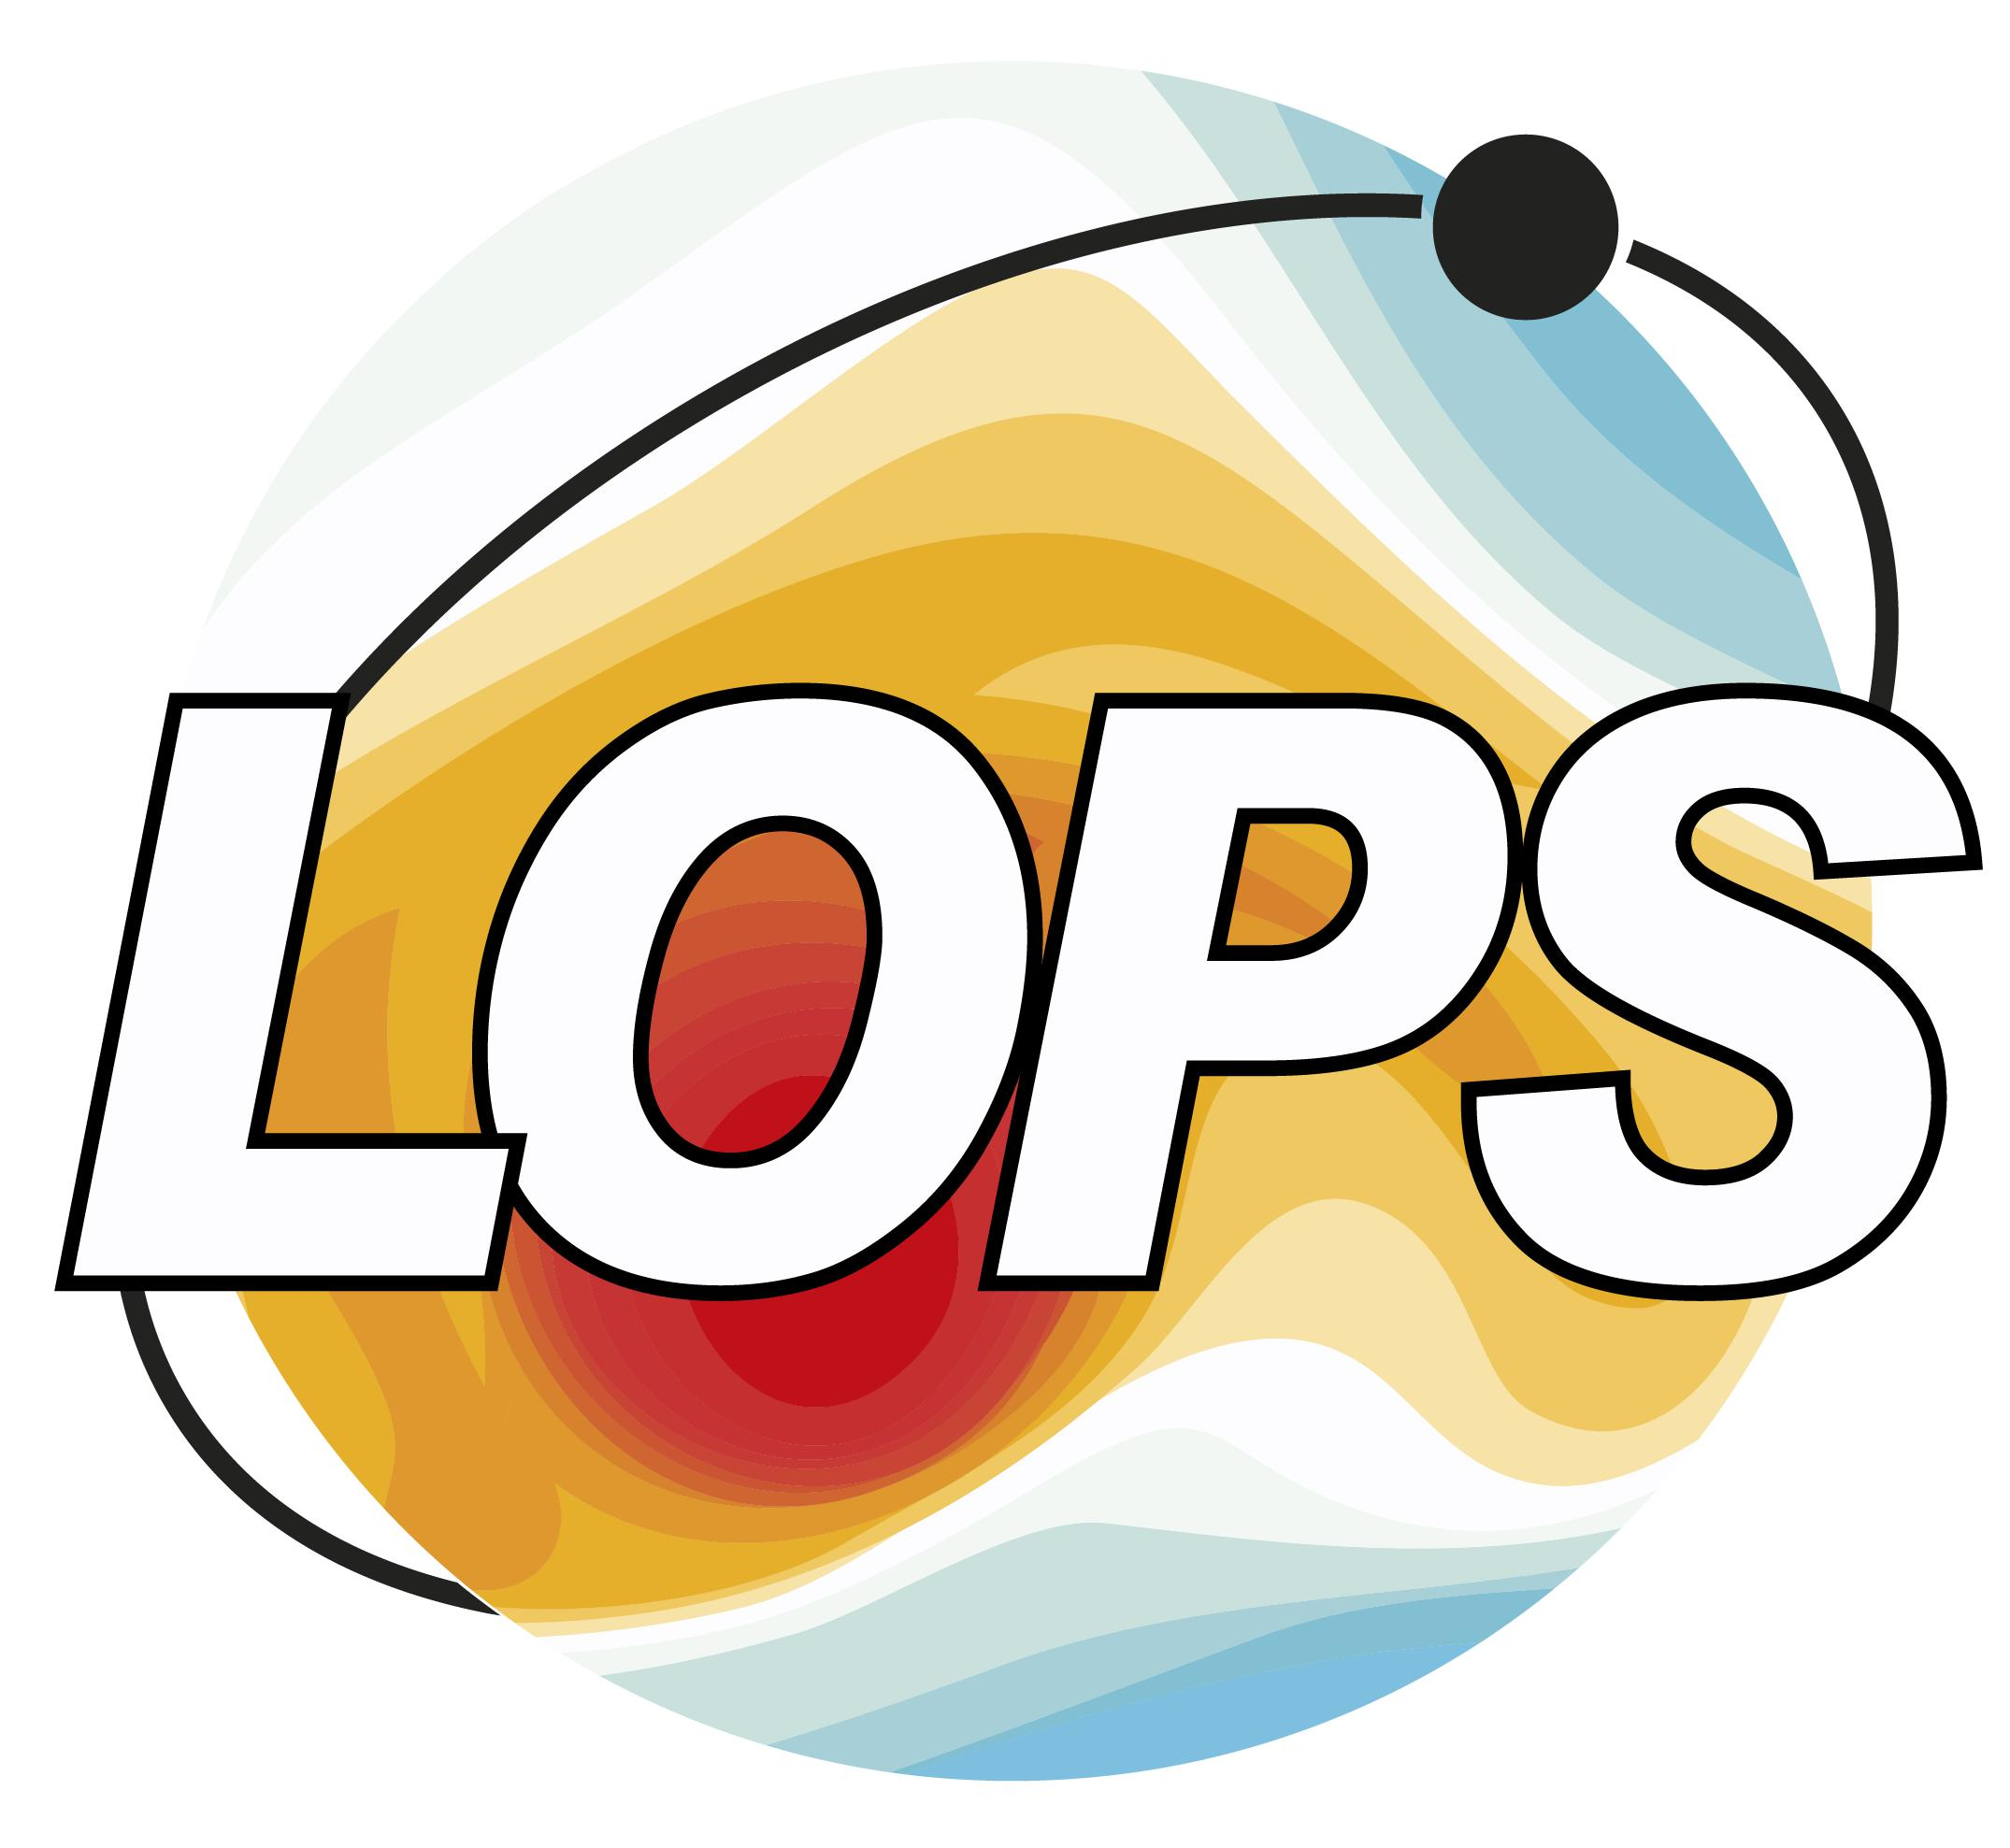 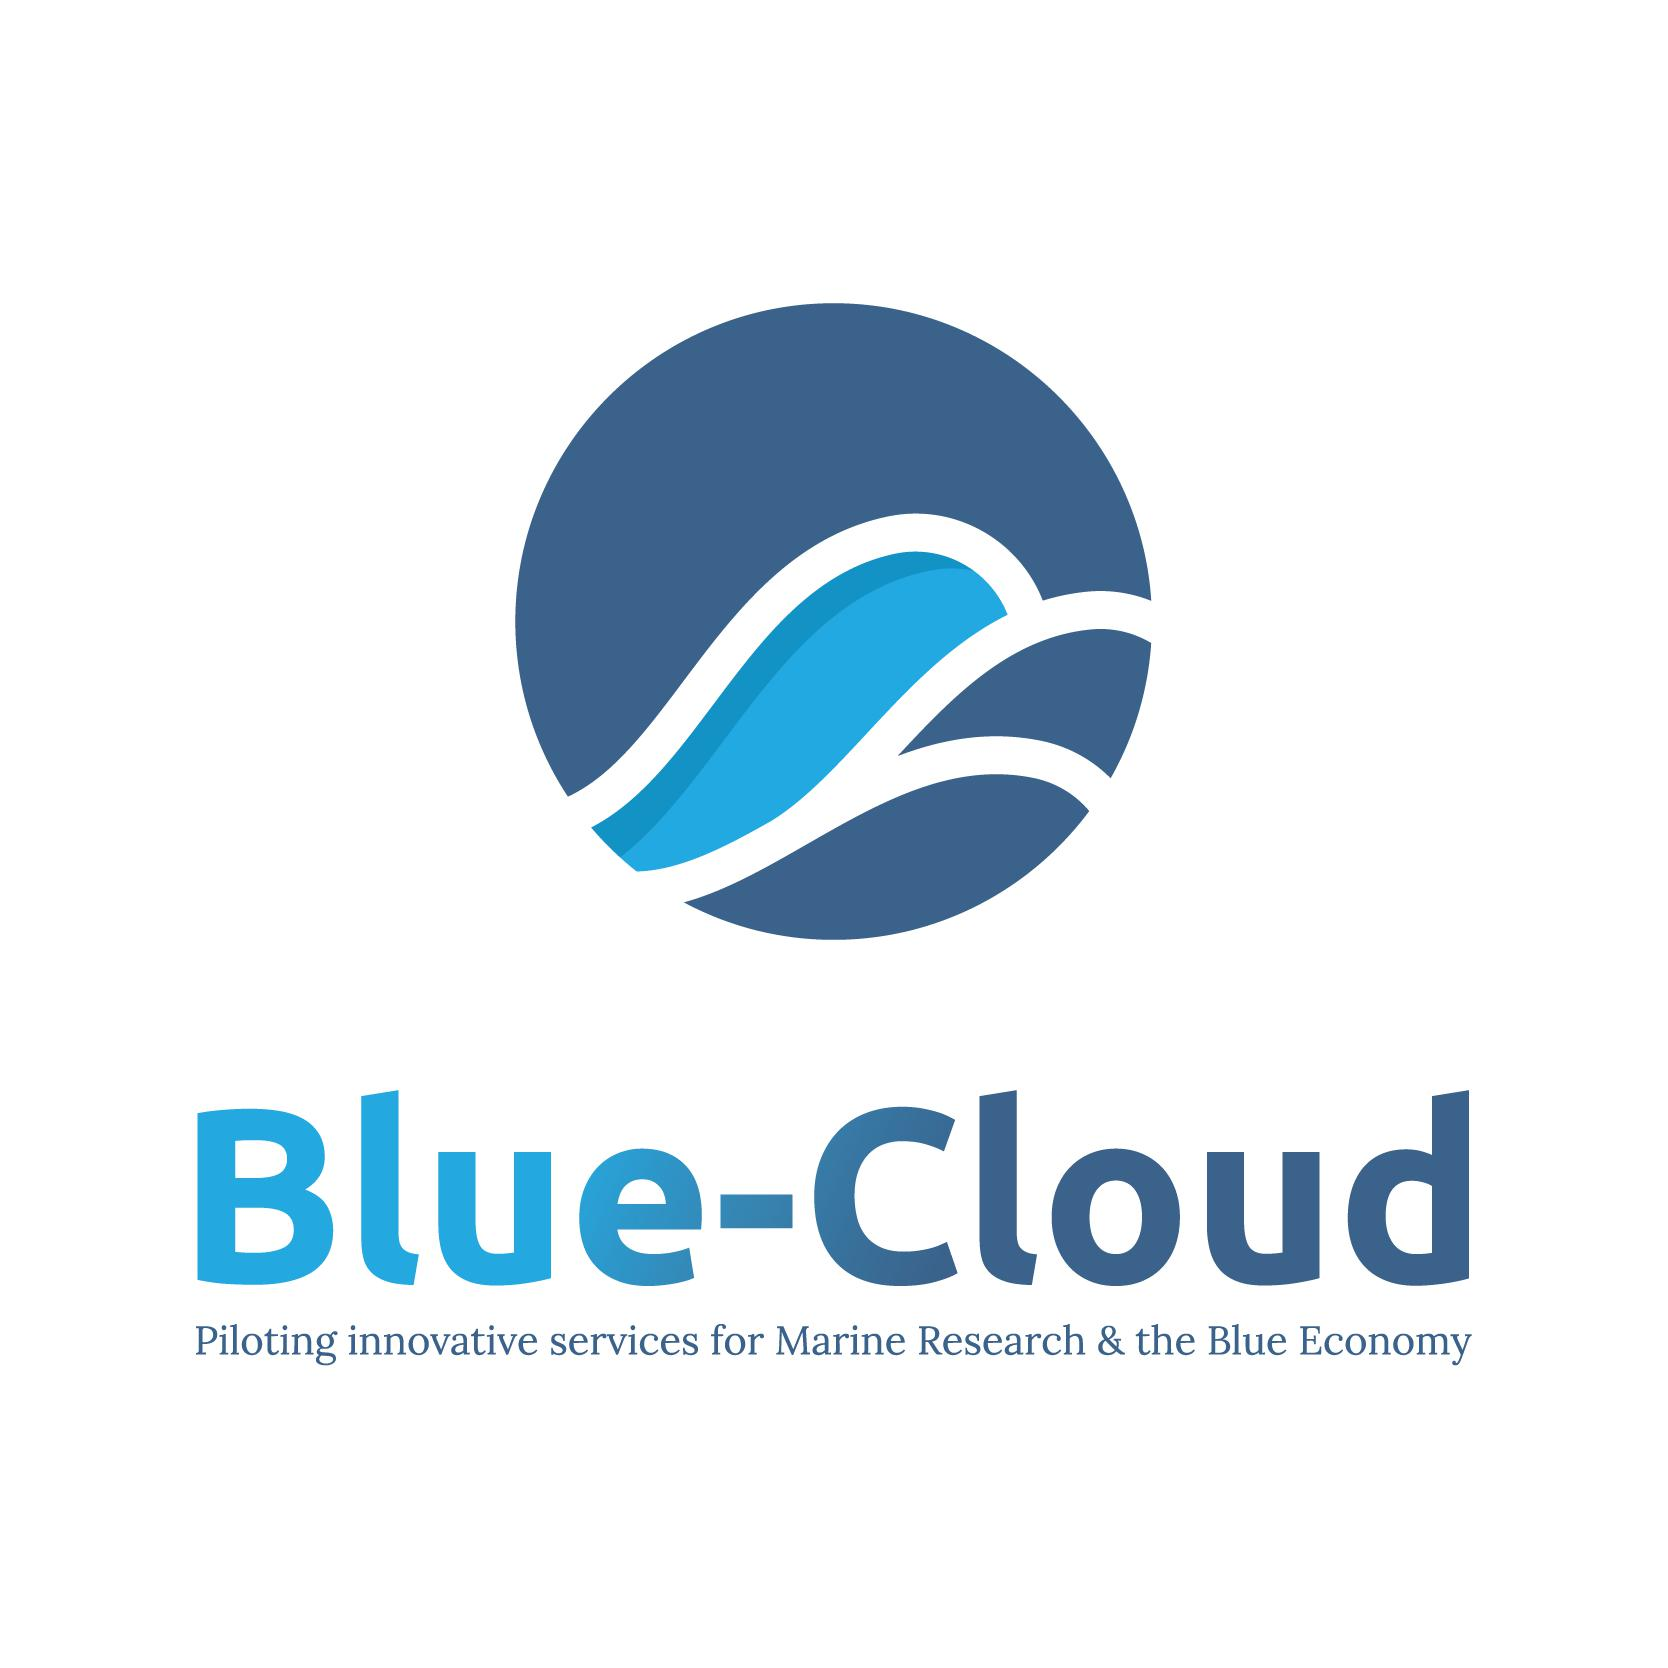</center>
</div>

In [1]:
import xarray as xr
import numpy as np

import pyxpcm
from pyxpcm.models import pcm

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import Plotter
from Plotter import Plotter #new class for plots in pyxpcm

from PIL import Image

import importlib

import concurrent.futures
from tqdm import tqdm

import subprocess

## Model parameters
***

__Model parameters__

In this section you will provide the parameters you want to use for designing your model: you should choose the __number of classes__ and provide the name that the variable (__feature__) will have in the model.

For the number of classes *K* you can choose a low number at the beginning (around 6). In the plot section you will optimize the number of classes using the [BIC plot](#BIC_plot). Then you will use the optimized number of classes to train the model again.

In [2]:
# number of classes
K=6

# name of variable (feature)
var_name_mdl = 'temperature' # in model

## Load training dataset
***

__Choose training dataset__

The training dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

You should provide your CMEMS __user name__ and __password__ below.

In [3]:
CMEMS_user = 'agarcia6'
CMEMS_password = '1802910672Aa#'

Data comes from  monthly mean fields of *GLOBAL_REANALYSIS_PHY_001_030* product, an eddy-resolving reanalysis with 1/12° horizontal resolution and 50 vertical levels (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=GLOBAL_REANALYSIS_PHY_001_030) for getting all the information about the dataset). As an exemple, we propose to you a selection covering the Mediterranean sea during 2018.

If you feel confident you can modify downloading parameters (cell below) to test other dataset selections than the one we propose here (covering the Mediterranean). You can also test other variables, but do not forget to change variables names in the cell above. And be careful with memory limits: do not choose very big geographical extents or very long time series.

In [4]:
# geographical extent
geo_extent = [-5, 35, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2018-01-01", "2018-12-31"] # ["min date", "max_date"]
# variable to be predict
var_name_ds = 'thetao' # name in dataset

__Load training dataset__

Training dataset is download from __CMEMS__ servers using a Motu client and saved as a NetCDF file in *datasets/* folder in your workspace. Dowloading will take some minutes.

In [5]:
!pip install motuclient --upgrade
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s GLOBAL_REANALYSIS_PHY_001_030-TDS -d global-reanalysis-phy-001-030-monthly \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v so -v ' + var_name_ds + ' -o datasets -f global-reanalysis-phy-001-030-monthly_med.nc'
sp = subprocess.call(bashCommand, shell=True)
file_path = 'datasets/global-reanalysis-phy-001-030-monthly_med.nc'

Training dataset is loaded from the NetCDF file using *xarray* library.

In [6]:
ds = xr.open_dataset(file_path)

# some format
ds['depth'] = -np.abs(ds['depth'].values)
ds.depth.attrs['axis'] = 'Z'
z_dim = 'depth'

print(ds)

<xarray.Dataset>
Dimensions:    (depth: 41, latitude: 193, longitude: 481, time: 12)
Coordinates:
  * depth      (depth) float32 -0.494025 -1.541375 ... -1941.893 -2225.078
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 45.916668 46.0
  * time       (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude  (longitude) float32 -5.0 -4.9166665 -4.8333335 ... 34.916668 35.0
Data variables:
    thetao     (time, depth, latitude, longitude) float32 ...
    so         (time, depth, latitude, longitude) float32 ...
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

Quick plot of the training dataset. Please, choose time and depth slide if needed.

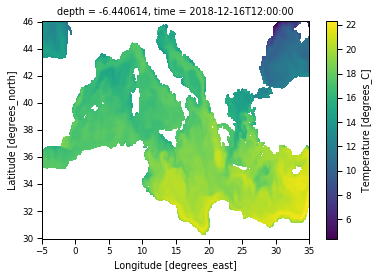

In [7]:
ds[var_name_ds].isel(time=11, depth=5).plot();

## Create and train model
***

In this section, you can create your own model using the number of classes *K* and the feature given as input. Then, the model is trained (__fitted__) to the training dataset and profiles are classified (__predict__) in order to make some useful plots in the next section.

### Create PCM

In [8]:
# pcm feature
z = ds[z_dim][0:30]
pcm_features = {var_name_mdl: z}

m = pcm(K=K, features=pcm_features)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: False
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>

### Fit model

In [9]:
# Variable to be fitted {variable name in model: variable name in dataset}
features_in_ds = {var_name_mdl : var_name_ds}

m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)
m

<pcm 'gmm' (K: 6, F: 1)>
Number of class: 6
Number of feature: 1
Feature names: odict_keys(['temperature'])
Fitted: True
Feature: 'temperature'
	 Interpoler: <class 'pyxpcm.utils.Vertical_Interpolator'>
	 Scaler: 'normal', <class 'sklearn.preprocessing._data.StandardScaler'>
	 Reducer: True, <class 'sklearn.decomposition._pca.PCA'>
Classifier: 'gmm', <class 'sklearn.mixture._gaussian_mixture.GaussianMixture'>
	 log likelihood of the training set: 19.583675

## Development plots
***

The plots in this section will help you to __optimize__ the model parameters (specially the number of classes) and to take a look on how the model is working.

#### __1. Mask__

When fitting the model, the pyxpcm sorfware __preprocessed__ the data to use profiles without NaN values. NaNs can be found when the profile is not depth enough, for example. Profiles with NaN values are masked and they are not used for fitting the model.  

You can plot the mask below to know how is the dataset which is actually used to fit the model. As we are working with a time series, you should choose the time slide to be plotted.

In [ ]:
mask = ds.isel(time=7).pyxpcm.mask(m, features=features_in_ds, dim=z_dim)
mask.plot()

#### __2. BIC__
<a id='BIC_plot'></a>

The BIC (Bayesian Information Criteria) is used to __optimize the number of classes__ in the model, trying not to over-fit or under-fit the data. For calculating this index, the model is fitted to the training dataset for a range of K values from 0 to 20, doing 10 runs each time to calculate the standard deviation. The __minimum__ in the BIC curve will give to you the best number of classes to be used.

For each run, a sub-dataset of the training dataset is used, as profiles should not be correlated neither spatially nor temporally to get a minimum. Spatial and temporal correlation in the training dataset are user inputs that should be given below. For our example in the Mediterranean sea, values have been optimized. If you want to try another geographical selection or another variable you may change this numbers.

You can also choose the number of runs and the maximum number of classes, taking in to account that increasing this numbers will increase the computation time. Calculation is parallelized but it still take some minutes.

remapping function 

In [21]:
#function remapping grid using start point and grid extent

def mapping_corr_dist(corr_dist, start_point, grid_extent):

    # angular distance d/earth's radius (km)
    delta = corr_dist/6371
    
    # all in radians (conversion at the end)
    grid_extent = grid_extent*np.pi/180
    start_point = start_point*np.pi/180
    
    ### while loop for lat nord ###
    max_lat = grid_extent[3]
    lat2 = -np.pi/2 
    lat1 = start_point[1]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_lats = [lat1]
    while lat2 < max_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) + np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2

        
    ### while loop for lat sud ###
    min_lat = grid_extent[2]
    lat2 = np.pi/2 
    lat1 = start_point[1]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while lat2 > min_lat:
        lat2 = np.arcsin(np.sin(lat1)*np.cos(delta) - np.cos(lat1)*np.sin(delta))
        new_lats.append(lat2)
        lat1 = lat2
    
    new_lats = np.sort(new_lats)*180/np.pi
    
    ### while loop for lon east ###
    max_lon = grid_extent[1]
    lon2 = -np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = pi/2 donc cos(pi/2)=0 and sin(pi/2)=1
    new_lons = [lon1]
    dlon = np.arctan2(np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 < max_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    ### while loop for lon west ###
    min_lon = grid_extent[0]
    lon2 = np.pi
    lon1 = start_point[0]
    lat1 = start_point[1]
    # bearing = -pi/2 donc cos(-pi/2)=0 and sin(-pi/2)=-1
    dlon = np.arctan2(-np.sin(delta)*np.cos(lat1), np.cos(delta)-np.sin(lat1)*np.sin(lat1))
    while lon2 > min_lon:
        lon2 = lon1 + dlon
        new_lons.append(lon2)
        lon1 = lon2
        
    new_lons = np.sort(new_lons)*180/np.pi
    
    return new_lats, new_lons

In [ ]:
import pandas as pd
time_extent = np.array([ds.time.values.min(), ds.time.values.max()])
ds_time = ds.time
#ds_time.resample(time="3M").nearest(tolerance="3M")
ds_time.resample(time='3M').nearest()
plus_month_period = 3
time_vector = ds_time[1] + pd.DateOffset(months=plus_month_period)

In [ ]:
timep = np.random.choice(ds.time.values, 1, replace=False)
time_extent = np.array([ds.time.values.min(), ds.time.values.max()])
coor_time = 3 

In [ ]:
new_time = mapping_corr_time(coor_time=coor_time, start_point=timep, time_extent=time_extent)
s_ran = ds.sel(time=new_time, method='nearest')
index = np.unique(s_ran['time'], return_index=True)
s_ran.isel(time=index[1])

In [22]:
#function remapping in time

def mapping_corr_time(corr_time, start_point, time_extent):

    # we are supossing that 1 month is 30 days for using np.timedelta64
    
    
    ### while loop for bigger dates ###
    max_time = time_extent[1]
    time2 = time_extent[0]
    time1 = start_point[0]
    # bearing = 0 donc cos(0)=1 and sin(0)=0
    new_time = [time1]
    while time2 < max_time:
        time2 = time1 + np.timedelta64(corr_time*30,'D')
        new_time.append(time2)
        time1 = time2

        
    ### while loop for smaller dates ###
    min_time = time_extent[0]
    time2 = time_extent[1]
    time1 = start_point[0]
    # bearing = pi donc cos(pi)=-1 and sin(pi)=0
    while time2 > min_time:
        time2 = time1 - np.timedelta64(corr_time*30,'D')
        new_time.append(time2)
        time1 = time2
    
    new_time = np.sort(new_time)
    
    return new_time

__User input__

In [23]:
corr_dist = 40
corr_time = 8 # months
Nrun = 10
NK = 20
#only one time step
dsp = ds
#dsp = ds.isel(time=9)

Calculation using paralelisation

In [24]:
#start = time.time()

# grid extent
grid_extent = np.array([ds.longitude.values.min(), ds.longitude.values.max(), ds.latitude.values.min(), ds.latitude.values.max()])
# time extent
time_extent = np.array([ds.time.values.min(), ds.time.values.max()])

class_list = np.arange(0,NK) # this is the list of arguments to iterate over, for instance nb of classes for a PCM

def BIC_cal(X, k):
    """ Function to run on a single argument """
    
    #create model
    m = pcm(K=k+1, features=pcm_features)
    #fit model
    m._classifier.fit(X)
    
    #calculate LOG LIKEHOOD
    llh = m._classifier.score(X)

    # calculate Nb of independant parameters to estimate
    # we suppose m._classifier.covariance_type == 'full'
    _, n_features = m._classifier.means_.shape
    cov_params = m._classifier.n_components * n_features * (n_features + 1) / 2.
    mean_params = n_features * m._classifier.n_components
    Nf = int(cov_params + mean_params + m._classifier.n_components - 1)
    
    #calculate bic
    N_samples = X.shape[0]
    BIC = (-2 * llh * N_samples + Nf * np.log(N_samples))
    #BIC = m._classifier.bic(X)
    
    return BIC, k 

BIC = np.zeros((NK,Nrun)) 
#BIC = []
for run in range(Nrun):
    #print('run=' + str(run))
    
    #random fist point
    latp = np.random.choice(dsp.latitude.values, 1, replace=False)
    lonp = np.random.choice(dsp.longitude.values, 1, replace=False)
    timep = np.random.choice(ds.time.values, 1, replace=False)
    #mapping
    new_lats, new_lons = mapping_corr_dist(corr_dist=corr_dist, start_point=np.concatenate((lonp,latp)), grid_extent=grid_extent)
    new_time = mapping_corr_time(corr_time=corr_time, start_point=timep, time_extent=time_extent)
    print(new_time)
    
    ds_ran = dsp.sel(latitude=list(new_lats), longitude=list(new_lons), time=new_time, method='nearest')
    # if repeated time values
    index = np.unique(ds_ran['time'], return_index=True)
    ds_ran.isel(time=index[1])
    
    # pre-processing
    m = pcm(K=4, features=pcm_features)
    X , sampling_dims = m.preprocessing(ds_ran, features=features_in_ds, dim=z_dim, action='fit')
    
    #BIC computation in parallel
    results = []
    ConcurrentExecutor = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    with ConcurrentExecutor as executor:
        future_to_url = {executor.submit(BIC_cal, X, k): k for k in class_list}
        futures = concurrent.futures.as_completed(future_to_url)
        futures = tqdm(futures, total=len(class_list))
        for future in futures:
            traj = None
            try:
                traj = future.result()
            except Exception as e:
                #pass
                raise
            finally:
                results.append(traj)
    results = [r for r in results if r is not None]  # Only keep non-empty results
    results.sort(key=lambda x:x[1])
    BIC[:,run] = np.array([i[0] for i in results])
    
#end = time.time()
#print((end - start)/60)

['2017-08-19T00:00:00.000000000' '2018-04-16T00:00:00.000000000'
 '2018-12-12T00:00:00.000000000' '2019-08-09T00:00:00.000000000']


100%|██████████| 20/20 [00:58<00:00,  2.93s/it]


['2017-11-18T12:00:00.000000000' '2018-07-16T12:00:00.000000000'
 '2019-03-13T12:00:00.000000000']


100%|██████████| 20/20 [00:36<00:00,  1.82s/it]


['2017-06-23T12:00:00.000000000' '2018-02-18T12:00:00.000000000'
 '2018-10-16T12:00:00.000000000' '2019-06-13T12:00:00.000000000']


100%|██████████| 20/20 [00:54<00:00,  2.70s/it]


['2017-08-19T00:00:00.000000000' '2018-04-16T00:00:00.000000000'
 '2018-12-12T00:00:00.000000000' '2019-08-09T00:00:00.000000000']


  0%|          | 0/20 [00:00<?, ?it/s]

['2017-07-24T00:00:00.000000000' '2018-03-21T00:00:00.000000000'
 '2018-11-16T00:00:00.000000000' '2019-07-14T00:00:00.000000000']


100%|██████████| 20/20 [01:08<00:00,  3.45s/it]


['2017-05-21T12:00:00.000000000' '2018-01-16T12:00:00.000000000'
 '2018-09-13T12:00:00.000000000' '2019-05-11T12:00:00.000000000']


100%|██████████| 20/20 [00:57<00:00,  2.88s/it]


['2017-07-19T12:00:00.000000000' '2018-03-16T12:00:00.000000000'
 '2018-11-11T12:00:00.000000000' '2019-07-09T12:00:00.000000000']


100%|██████████| 20/20 [01:12<00:00,  3.64s/it]


['2017-05-24T00:00:00.000000000' '2018-01-19T00:00:00.000000000'
 '2018-09-16T00:00:00.000000000' '2019-05-14T00:00:00.000000000']


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


['2017-07-19T12:00:00.000000000' '2018-03-16T12:00:00.000000000'
 '2018-11-11T12:00:00.000000000' '2019-07-09T12:00:00.000000000']


100%|██████████| 20/20 [01:00<00:00,  3.05s/it]


['2017-09-18T12:00:00.000000000' '2018-05-16T12:00:00.000000000'
 '2019-01-11T12:00:00.000000000']


100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


*PLOT*

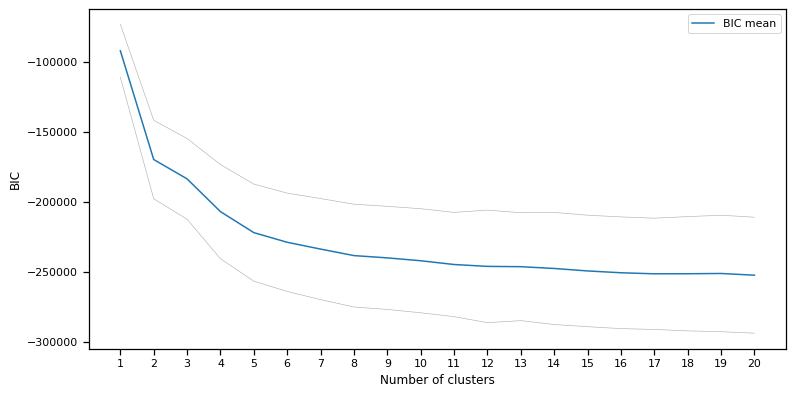

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), dpi=90)
BICmean = np.mean(BIC,axis=1)
BICstd = np.std(BIC,axis=1)
normBICmean = (BICmean-np.mean(BICmean))/np.std(BICmean)
normBICstd = np.std(normBICmean)
#plt.plot(np.arange(kmax)+1,(BIC-np.mean(BIC))/np.std(BIC),label='Raw BIC')
plt.plot(np.arange(NK)+1,BICmean,label='BIC mean')
plt.plot(np.arange(NK)+1,BICmean+BICstd,color=[0.7]*3,linewidth=0.5)
plt.plot(np.arange(NK)+1,BICmean-BICstd,color=[0.7]*3,linewidth=0.5)
plt.ylabel('BIC')
plt.xlabel('Number of clusters')
plt.xticks(np.arange(NK)+1)
plt.legend()

__Optimized number of classes__

In [26]:
op_classes = np.argmin(BICmean)+1
op_classes

20

If this is not the number of classes you chose in the beginning of the notebook, don't worry, you will fit your model again with the good number of classes at the end of the notebook.

#### __3. Robustness__

The PCM robustness represent the __probability__ of a profile to belong to a class. If a lot of profiles show very low values you should maybe change the number of classes. You should chose the time slide you want to plot in the function below.

In [27]:
m.fit(ds, features=features_in_ds, dim=z_dim);
m.predict_proba(ds, features=features_in_ds, dim=z_dim, inplace=True);
ds.pyxpcm.robustness(m, inplace=True)
ds.pyxpcm.robustness_digit(m, inplace=True)

<xarray.Dataset>
Dimensions:             (depth: 41, latitude: 193, longitude: 481, pcm_class: 4, time: 12)
Coordinates:
  * depth               (depth) float32 -0.494025 -1.541375 ... -2225.078
  * latitude            (latitude) float64 30.0 30.08 30.17 ... 45.83 45.92 46.0
  * time                (time) datetime64[ns] 2018-01-16T12:00:00 ... 2018-12-16T12:00:00
  * longitude           (longitude) float64 -5.0 -4.917 -4.833 ... 34.92 35.0
Dimensions without coordinates: pcm_class
Data variables:
    thetao              (time, depth, latitude, longitude) float32 nan ... nan
    so                  (time, depth, latitude, longitude) float32 ...
    PCM_LABELS          (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_POST            (pcm_class, time, latitude, longitude) float64 nan ... nan
    PCM_ROBUSTNESS      (time, latitude, longitude) float64 nan nan ... nan nan
    PCM_ROBUSTNESS_CAT  (time, latitude, longitude) int64 5 5 5 5 5 ... 5 5 5 5
Attributes:
    title:                         Monthly mean fields for product GLOBAL_REA...
    references:                    http://marine.copernicus.eu
    credit:                        E.U. Copernicus Marine Service Information...
    licence:                       http://marine.copernicus.eu/services-portf...
    contact:                       servicedesk.cmems@mercator-ocean.eu
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    institution:                   Mercator Ocean
    Conventions:                   CF-1.6
    area:                          GLOBAL
    product:                       GLOBAL_REANALYSIS_001_030
    dataset:                       global-reanalysis-001-030-monthly
    source:                        MERCATOR GLORYS12V1
    product_user_manual:           http://marine.copernicus.eu/documents/PUM/...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:                       
    history:                       Data extracted from dataset http://localho...

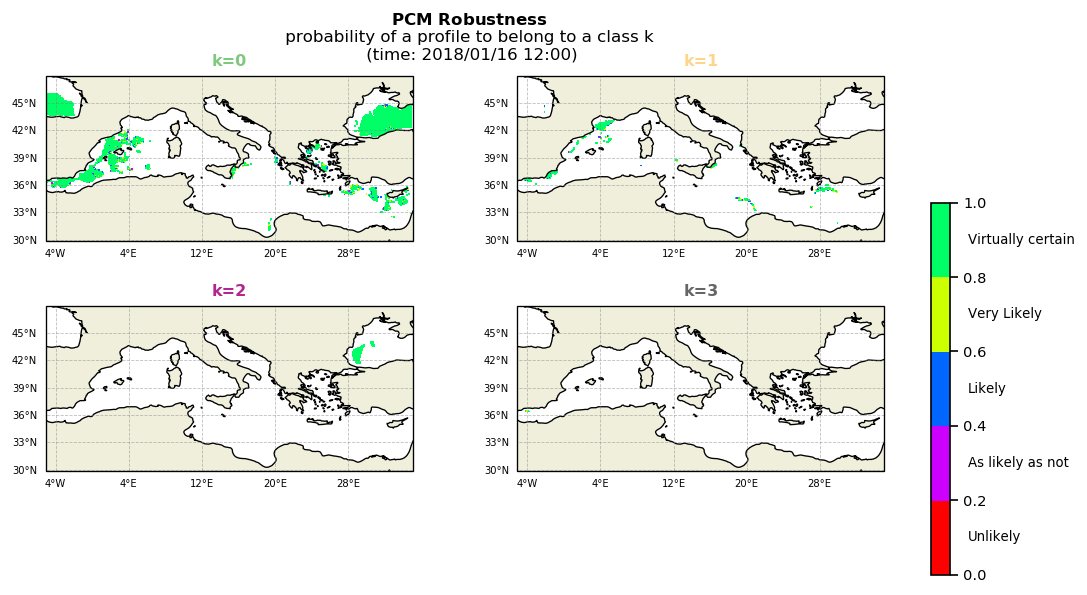

In [28]:
P = Plotter(ds, m)
P.plot_robustness(time_slice="2018-01-01")

## Refit and save model
***

As you know know which is the __best number of classes__ to be used with your training dataset, you can train (fit) the model again with the good number of classes.

In [ ]:
# goog number of classes
K = 8

m = pcm(K=K, features=pcm_features)
m.fit_predict(ds, features=features_in_ds, dim=z_dim, inplace=True)

If you are happy with you model, you can save it in the *models/* folder and use it in the *predict_PCMlabels_and_plot.IPYNB* notebook to classify (predict) a dataset and plot the results corresponding to __ocean patterns indicators__.

In [29]:
m.to_netcdf('models/tests_model.nc')